In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import tensorflow as tf
import numpy as np
import pickle
import pandas as pd
import matplotlib.pyplot as plt
import glob
import re
import cv2 as cv
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder
from tensorflow.keras import datasets,layers,models
from tqdm import tqdm
from typing import List

In [3]:
def read_photo_path_data(path = '/content/drive/My Drive/aueb/') -> pd.DataFrame:
  """
  Reads the file paths of every jpg file in the chosen directory
  Returns a DataFrame Object
  """
  path = path +'**/*.jpg' # Includes all jpgs from all subdirectories
  file_paths = glob.glob(path, recursive = True)
  if not file_paths: # If glob didn't find any .jpg files
    raise ValueError(f"Did not find any .jpg files on path {path}")
  return pd.DataFrame(file_paths)


def extract_id_from_file_path(dataframe: pd.DataFrame,column_location=0) -> pd.Series:
  """ DEPRICIATED DEPRICIATED DEPRICIATED DEPRICIATED DEPRICIATED DEPRICIATED 
  Extracts the product id (4 digit number) contained in the file path
  Column location is used to locate the position of the path column in
  the dataframe,default in the first column (0).
  """
  regex = r"/(\d+)_"
  return dataframe.iloc[:,column_location].str.extract(regex)


def data_preproccessing(dataframe: pd.DataFrame) -> pd.DataFrame:
  """
  Extracts the ID from the file path and filters out any products
  with only one picture
  """
  dataframe.rename(columns = {0:'path'},inplace = True)
  dataframe['id'] = extract_id_from_file_path(dataframe)
  #dataframe = filter_products_with_single_photos(dataframe)
  return dataframe


def extract_label_from_dataframe(df: pd.DataFrame) -> pd.Series:
  """ Extracts the image label from path in the FIRST COLUMN.
  It is assumed that image is named as {class_label}_{counter}.jpg"""
  return df.iloc[:,0].str.split("/").str[-1].str.split("_").str[0]


def images_to_ndarray(photo_path : str, IMG_SIZE = (150,150))-> np.array:
  """
  The function reads the images supplied by 
  photo_paths parameter. The function reads an image from path,
  resizes it and turns into grayscale
  """
  nd_array = cv.imread(photo_path)
  return cv.resize(nd_array, IMG_SIZE)

In [4]:
# Hyper Parameters
IMG_SIZE = (150,150)
TEST_SIZE = 0.25
BATCH_SIZE = 32
EPOCHS = 15

In [7]:
photo_path_data = read_photo_path_data(path = '/content/drive/My Drive/aueb/compressed/') # read image paths PLACE YOUR PATH HERE!!!
photo_path_data['class_label'] = extract_label_from_dataframe(photo_path_data) # extract label and assign it to column
photo_path_data.rename(columns = {0:'path'},inplace = True)
photo_path_data.head(1000)


ValueError: ignored

In [ ]:
#Reading Images may take a long time (>30min)
X = [images_to_ndarray(im, IMG_SIZE = IMG_SIZE) for im in tqdm(photo_path_data['path'])]
X = np.array(X)
Y = np.array(photo_path_data['class_label'])

100%|██████████| 4678/4678 [34:52<00:00,  2.24it/s]


In [ ]:
encoder = OrdinalEncoder()
Y = encoder.fit_transform(Y.reshape(-1,1))

In [ ]:
X_TRAIN, X_TEST, Y_TRAIN, Y_TEST = train_test_split(X,Y,test_size = TEST_SIZE, stratify = Y, random_state =42)
X_TRAIN = X_TRAIN/255
X_TEST = X_TEST/255

In [ ]:
print(f"Number of Training Images {X_TRAIN.shape[0]}")
print(f"Number of Test Images {X_TEST.shape[0]}")

Number of Training Images 3508
Number of Test Images 1170


In [ ]:
print(type(X_TRAIN))
print(type(Y_TRAIN))

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


In [ ]:
# Convolution Model Building
# Custom Network Hooray
conv_model = models.Sequential()
conv_model.add(layers.Conv2D(64, (3,3), activation = 'relu', input_shape = (150,150,3)))
conv_model.add(layers.Conv2D(64, (3,3), activation = 'relu'))
conv_model.add(layers.MaxPooling2D(2,2))
conv_model.add(layers.Conv2D(64, (3,3), activation = 'relu'))
conv_model.add(layers.Conv2D(64, (3,3), activation = 'relu'))
conv_model.add(layers.MaxPooling2D(2,2))
conv_model.add(layers.Flatten())
conv_model.add(layers.Dense(4096,activation = 'relu'))
conv_model.add(layers.Dense(len(np.unique(Y_TRAIN)),activation = 'softmax'))
conv_model.summary()
conv_model.compile(optimizer = 'adam',
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(),
                  metrics=['accuracy'])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 64)      1792      
                                                                 
 conv2d_1 (Conv2D)           (None, 146, 146, 64)      36928     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 73, 73, 64)       0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 71, 71, 64)        36928     
                                                                 
 conv2d_3 (Conv2D)           (None, 69, 69, 64)        36928     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 34, 34, 64)       0         
 2D)                                                    

In [ ]:
from tensorflow.python.keras.callbacks import EarlyStopping
es = EarlyStopping(
    monitor   = 'accuracy', # which metric we want to use as criterion to stop training
    min_delta = 0, # Minimum change in the monitored quantity to qualify as an improvement
    patience  = 3, # we 3 epochs before stopping
    verbose   = 1, # verbosity level
    mode      = 'auto',
    restore_best_weights = True)

In [ ]:
history = conv_model.fit(X_TRAIN,Y_TRAIN,
                         epochs = EPOCHS,
                         validation_split = 0.25,
                         callbacks = [es])

Epoch 1/15
83/83 [==============================] - 32s 226ms/step - loss: 3.9142 - accuracy: 0.2136 - val_loss: 1.9787 - val_accuracy: 0.5815
Epoch 2/15
83/83 [==============================] - 13s 160ms/step - loss: 0.8420 - accuracy: 0.8069 - val_loss: 1.0665 - val_accuracy: 0.7605
Epoch 3/15
83/83 [==============================] - 13s 158ms/step - loss: 0.1062 - accuracy: 0.9738 - val_loss: 1.5033 - val_accuracy: 0.7674
Epoch 4/15
83/83 [==============================] - 13s 160ms/step - loss: 0.0688 - accuracy: 0.9901 - val_loss: 1.1696 - val_accuracy: 0.8039
Epoch 5/15
83/83 [==============================] - 13s 159ms/step - loss: 0.0132 - accuracy: 0.9962 - val_loss: 1.2908 - val_accuracy: 0.7936
Epoch 6/15
83/83 [==============================] - 13s 151ms/step - loss: 0.0477 - accuracy: 0.9913 - val_loss: 1.4524 - val_accuracy: 0.7480
Epoch 7/15
83/83 [==============================] - 12s 151ms/step - loss: 0.0506 - accuracy: 0.9837 - val_loss: 1.6228 - val_accuracy: 0.7469

In [ ]:
def get_predictions_from_model(nnmodel, X_TEST : np.array ) -> np.array:
  """
  Returns the predictions for the convolutional model.
  Takes as parameters the X_TEST holdout dataset
  """
  predictions = nnmodel.predict(X_TEST)
  return np.argmax(predictions, axis = 1) # Get the most probable class


def get_original_labels(transformed_labels: np.array,encoder: OrdinalEncoder) -> np.array:
  """
  The function returns the original labels (before ordinal encoding).
  """
  return encoder.inverse_transform(transformed_labels.reshape(-1,1))


def plot_image(Image_array: np.array,
                predictions_array: pd.DataFrame,
                index: int
                ) -> None:
  fig, ax = plt.subplots(figsize = (8,8))
  ax.imshow(Image_array[index])
  plt.title(f"Predicted Label {predictions_array.iloc[index,0]}") # First Columns contains correct Predictions
  plt.axis('off')

def plot_multiple_images(Image_array: np.array,
                         predictions_array: pd.DataFrame,
                         indexes: List,
                         figsize: tuple,
                         ) -> None:
  fig = plt.figure(figsize = figsize)
  ROWS = len(indexes)
  for i,index in enumerate(indexes):

    fig.add_subplot(ROWS,1,(i+1)) # show images in single row
    plt.imshow(Image_array[index])
    plt.axis('off')
    plt.title(f"Predicted Label: {predictions_array.loc[index,'Ypred']}, True Label: {predictions_array.loc[index,'Ytrue']}")




In [ ]:
predictions = get_predictions_from_model(conv_model,X_TEST)
label_pred = get_original_labels(predictions,encoder)
label_true = get_original_labels(Y_TEST,encoder)

predictions_dataframe = pd.DataFrame({'Ytrue':label_true.reshape(-1), 'Ypred':label_pred.reshape(-1)})
correct_predictions = predictions_dataframe[predictions_dataframe['Ytrue']==predictions_dataframe['Ypred']]
false_predictions = predictions_dataframe[predictions_dataframe['Ytrue']!=predictions_dataframe['Ypred']]

In [ ]:
print(f"Test Sample size {X_TEST.shape[0]}")
print(f"Number of correct Predctions {correct_predictions.shape[0]}")
print(f"Accuracy of Test Dataset {correct_predictions.shape[0]/X_TEST.shape[0]:.4f}")

Test Sample size 1170
Number of correct Predctions 935
Accuracy of Test Dataset 0.7991


In [ ]:
correct_predictions

,Ytrue,Ypred
0,PEPSI COLA 1.5 L 1.47,PEPSI COLA 1.5 L 1.47
1,Skip XROMATISTA 40,Skip XROMATISTA 40
3,FAGEaggeladitsa 3yogurts,FAGEaggeladitsa 3yogurts
4,TSIPOURO TSILILI 200ML 3.63,TSIPOURO TSILILI 200ML 3.63
6,PEPSI TWIST 330 ML 0.62,PEPSI TWIST 330 ML 0.62
...,...,...
1165,MPIRA MONASTERE BLOND 500ML 1.95,MPIRA MONASTERE BLOND 500ML 1.95
1166,OLYMPOS greenmilk,OLYMPOS greenmilk
1167,DELTAfresko green,DELTAfresko green
1168,KARPOS Almond Protein,KARPOS Almond Protein


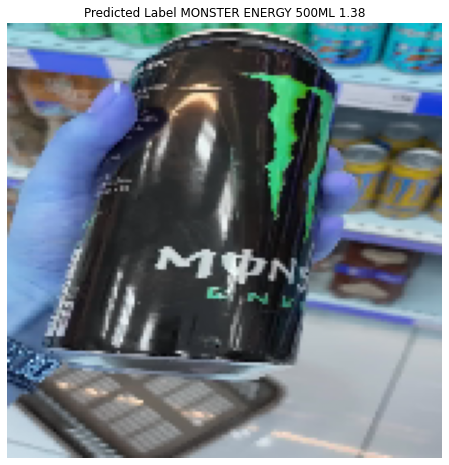

In [ ]:
plot_image(X_TEST,predictions_dataframe, 920)

In [ ]:
false_predictions_index = false_predictions.index
correct_predictions_index = correct_predictions.index
predictions_index = predictions_dataframe.index

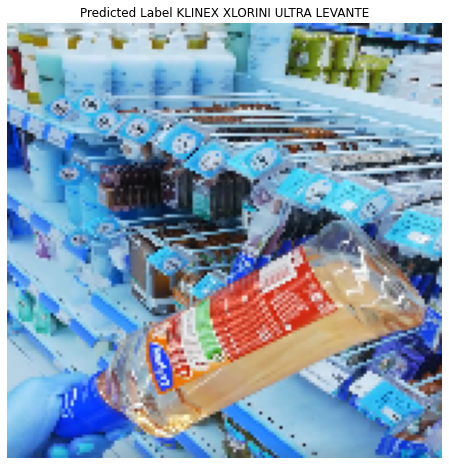

In [ ]:
#Plot some false predictions
plot_image(X_TEST, false_predictions, false_predictions_index[0])
# No wonder why the network didn't get it right

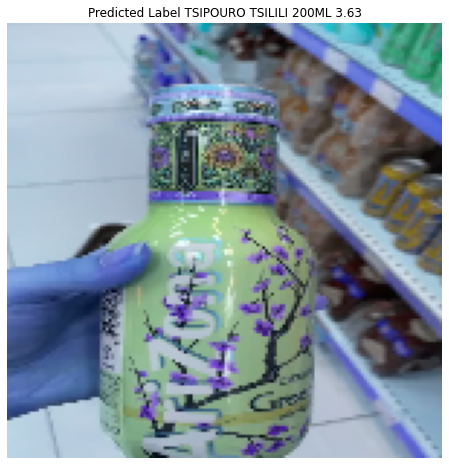

In [ ]:
plot_image(X_TEST, false_predictions, false_predictions_index[10])
# I can't understand it either

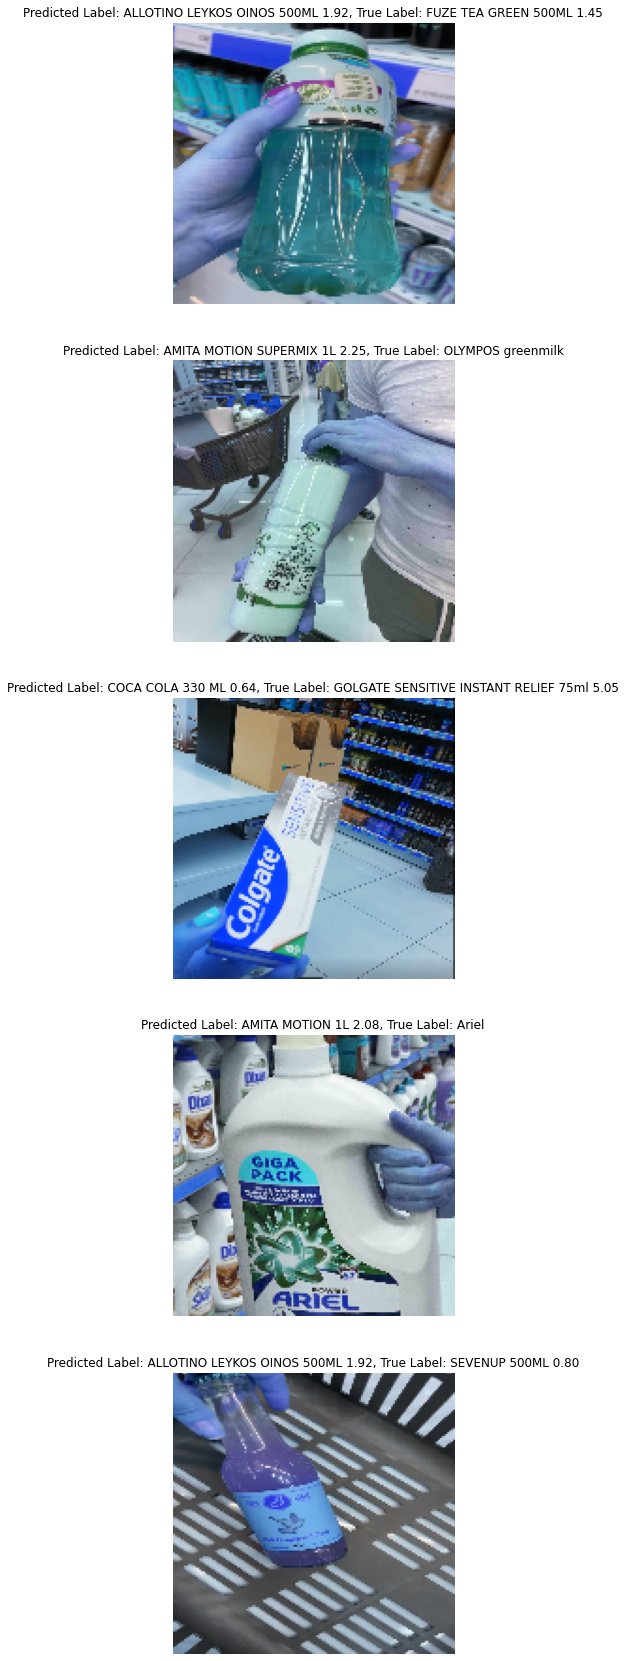

In [ ]:
# More False Predictions
plot_multiple_images(X_TEST, false_predictions, false_predictions_index[5:10], figsize = (30,30))

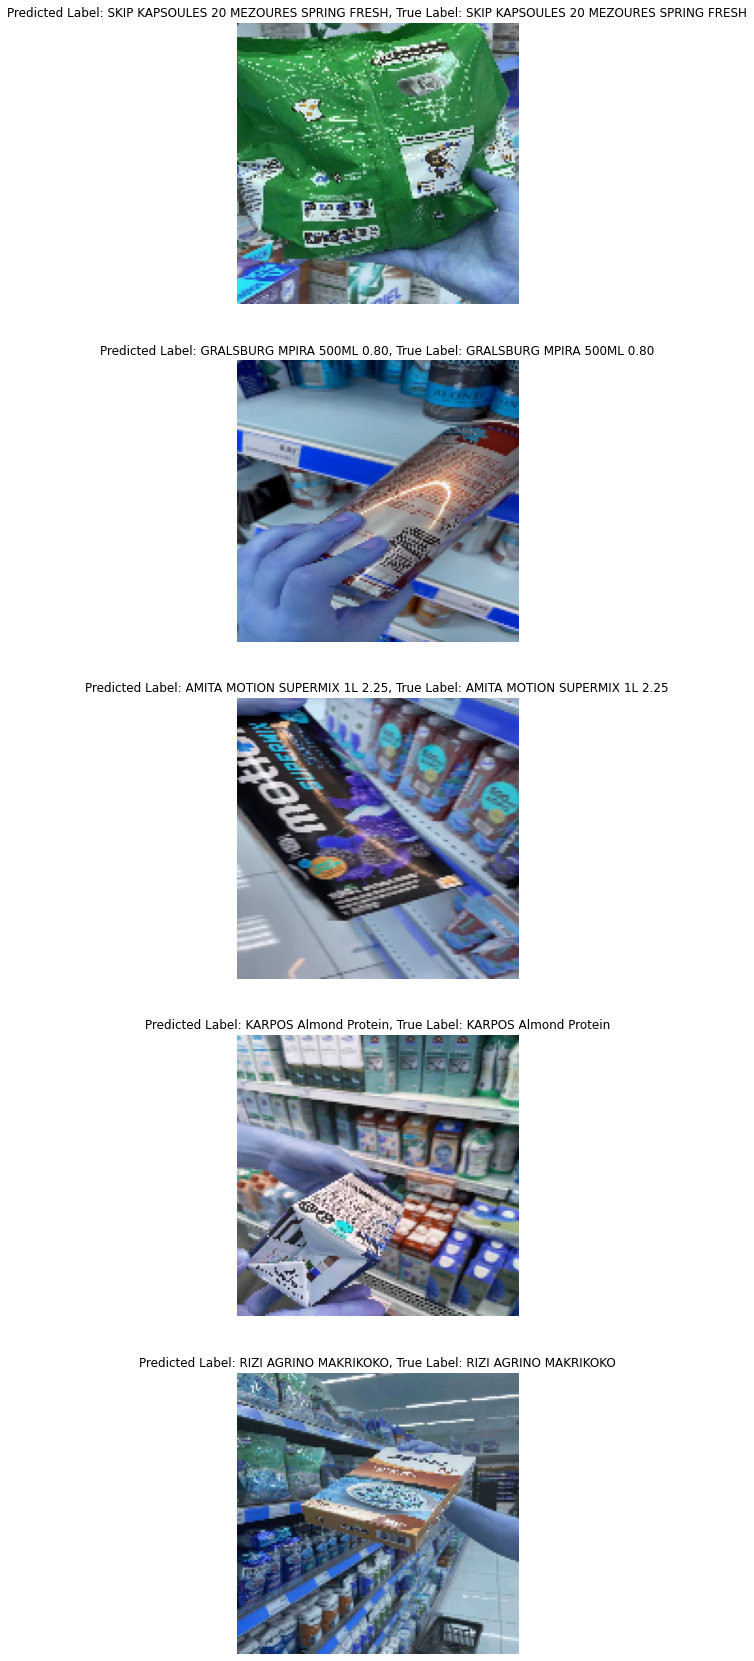

In [ ]:
# Correct Predictions
plot_multiple_images(X_TEST, correct_predictions, correct_predictions_index[10:15], figsize = (30,30))

In [ ]:
#Train VGG
from tensorflow.keras.applications import VGG16

In [ ]:
vgg16model = VGG16(include_top = False, input_shape = (150,150,3))

In [ ]:
#|vgg16model.summary()
vgg16model.trainable = False

flatten_layer = layers.Flatten()
dense_layer_1 = layers.Dense(4096, activation='relu')
dense_layer_2 = layers.Dense(4096, activation='relu')
prediction_layer = layers.Dense(len(np.unique(Y_TRAIN)),activation = 'softmax')



In [ ]:
vgg16 = models.Sequential([
    vgg16model,
    flatten_layer,
    dense_layer_1,
    dense_layer_2,
    prediction_layer
])

In [ ]:
vgg16.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 flatten_5 (Flatten)         (None, 8192)              0         
                                                                 
 dense_12 (Dense)            (None, 4096)              33558528  
                                                                 
 dense_13 (Dense)            (None, 4096)              16781312  
                                                                 
 dense_14 (Dense)            (None, 129)               528513    
                                                                 
Total params: 65,583,041
Trainable params: 50,868,353
Non-trainable params: 14,714,688
_________________________________________________________________


In [ ]:
vgg16.compile(optimizer = 'adam',
              loss = tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

In [ ]:
vgg16.fit(X_TEST,Y_TEST,
          epochs = EPOCHS,
          validation_split = 0.25,
          callbacks = [es])

Epoch 1/15
28/28 [==============================] - 6s 178ms/step - loss: 5.7225 - accuracy: 0.0969 - val_loss: 3.5651 - val_accuracy: 0.2867
Epoch 2/15
28/28 [==============================] - 3s 118ms/step - loss: 2.2839 - accuracy: 0.5165 - val_loss: 2.0983 - val_accuracy: 0.5461
Epoch 3/15
28/28 [==============================] - 3s 120ms/step - loss: 0.9630 - accuracy: 0.7640 - val_loss: 1.6182 - val_accuracy: 0.6143
Epoch 4/15
28/28 [==============================] - 3s 121ms/step - loss: 0.3072 - accuracy: 0.9168 - val_loss: 1.3650 - val_accuracy: 0.6519
Epoch 5/15
28/28 [==============================] - 3s 118ms/step - loss: 0.1546 - accuracy: 0.9635 - val_loss: 1.2380 - val_accuracy: 0.7133
Epoch 6/15
28/28 [==============================] - 3s 121ms/step - loss: 0.0680 - accuracy: 0.9840 - val_loss: 1.1312 - val_accuracy: 0.7099
Epoch 7/15
28/28 [==============================] - 3s 116ms/step - loss: 0.1016 - accuracy: 0.9749 - val_loss: 0.9963 - val_accuracy: 0.7406
Epoch 

In [ ]:
predictions = get_predictions_from_model(vgg16,X_TEST)
label_pred = get_original_labels(predictions,encoder)
label_true = get_original_labels(Y_TEST,encoder)

predictions_dataframe = pd.DataFrame({'Ytrue':label_true.reshape(-1), 'Ypred':label_pred.reshape(-1)})
correct_predictions = predictions_dataframe[predictions_dataframe['Ytrue']==predictions_dataframe['Ypred']]
false_predictions = predictions_dataframe[predictions_dataframe['Ytrue']!=predictions_dataframe['Ypred']]

In [ ]:
print(f"Test Sample size {X_TEST.shape[0]}")
print(f"Number of correct Predctions {correct_predictions.shape[0]}")
print(f"Accuracy of Test Dataset {correct_predictions.shape[0]/X_TEST.shape[0]:.4f}")

Test Sample size 1170
Number of correct Predctions 1109
Accuracy of Test Dataset 0.9479


In [ ]:
false_predictions_index = false_predictions.index
correct_predictions_index = correct_predictions.index
predictions_index = predictions_dataframe.index

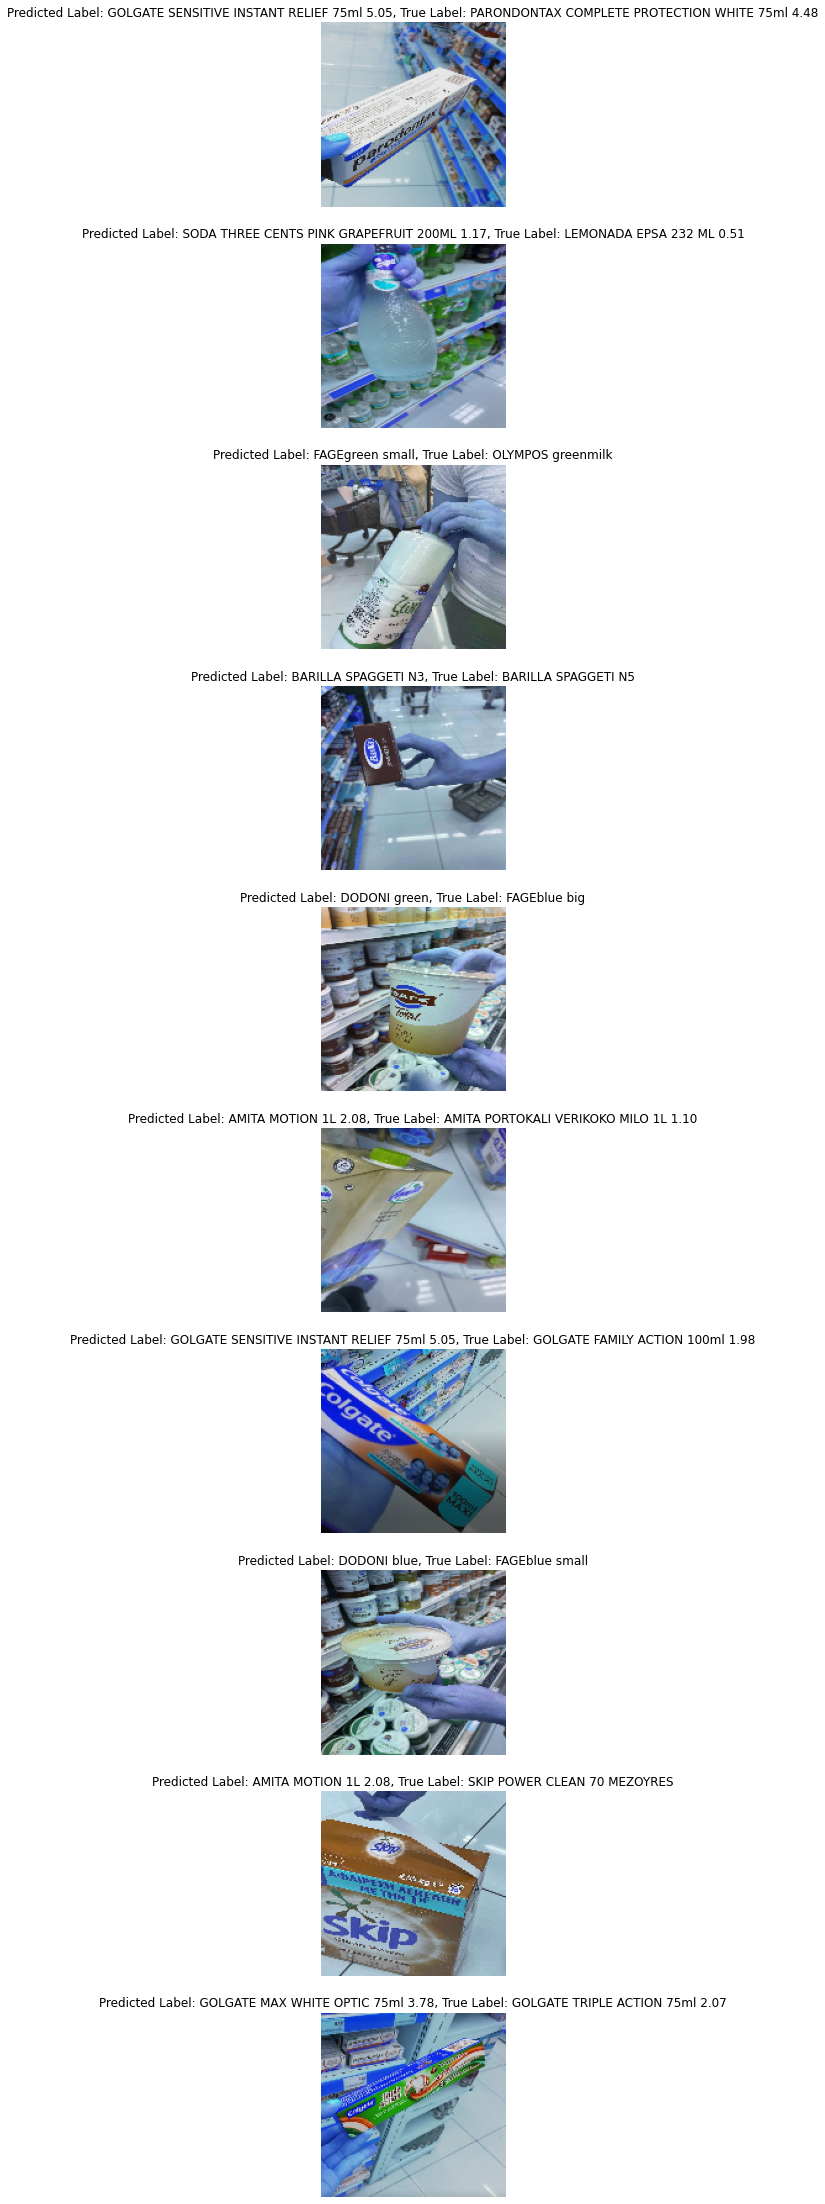

In [ ]:
plot_multiple_images(X_TEST, false_predictions, false_predictions_index[0:10], figsize = (40,40))